## Imports and stuff

In [66]:
import tensorflow as tf
import keras
from keras.layers import Dense,Dropout, Activation
from keras.models import Sequential
from keras.optimizers import *

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [67]:
X_train = np.array(np.load("X_train.npy"))
y_train = np.array(np.load("y_train.npy"))
X_dev = np.array(np.load("X_dev.npy"))
y_dev = np.array(np.load("y_dev.npy"))
X_test = np.array(np.load("X_test.npy"))
y_trainonehot = np.array(pd.get_dummies(y_train))
y_devonehot = np.array(pd.get_dummies(y_dev))

## Neural Network

In [69]:
print(X_train.shape, X_dev.shape, X_test.shape)
X_tot = np.concatenate([X_train, X_dev, X_test])
lol = PCA(n_components = 100)
X_tot = lol.fit_transform(X_tot)
X_tot = preprocessing.scale(X_tot)
X_train, X_dev, X_test = X_tot[:len(X_train)], X_tot[len(X_train):len(X_train)+len(X_dev)], X_tot[len(X_train)+len(X_dev):]
print(X_train.shape, X_dev.shape, X_test.shape)

(582, 193) (290, 193) (298, 193)
(582, 100) (290, 100) (298, 100)


In [70]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [71]:
scores = []
cv = 1
for i in range(cv):
    model = Sequential()
    model.add(Dense(40, input_dim = 11))
    model.add(Dropout(0.1))
    model.add(Activation('relu'))
    model.add(Dense(20))
    model.add(Dropout(0.1))
    model.add(Activation('relu'))
    model.add(Dense(15))
    model.add(Activation('softmax'))
    #optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    X = np.concatenate([X_train,X_dev])
    y = np.concatenate([y_trainonehot,y_devonehot])
    X,y = unison_shuffled_copies(X, y)
    
    history = model.fit(X,y, batch_size = 10, nb_epoch = 40, 
                        verbose = 0, validation_split = 0.1)
    score1 = model.evaluate(X_train,y_trainonehot,verbose=0)
    score2 = model.evaluate(X_dev,y_devonehot,verbose=0)
    print(score1[1], score2[1])
    scores.append((score1[1]+score2[1])/2)
print("Mean score:",np.mean(scores))

ValueError: Error when checking input: expected dense_19_input to have shape (None, 11) but got array with shape (872, 100)

In [ ]:
from sklearn.metrics import confusion_matrix
L = [np.argmax(x) for x in model.predict(X_dev)]
print(confusion_matrix(L,y_dev))

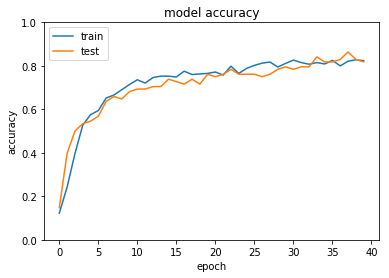

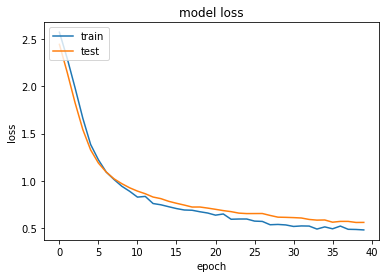

In [72]:
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0,1))
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [73]:
nn_pred = model.predict(X_test)
nn_pred = [np.argmax(nn_pred[i]) for i in range(len(nn_pred))]
np.savetxt('y_pred.txt', nn_pred, fmt="%d")
print(np.unique(nn_pred,return_counts=True))

ValueError: Error when checking : expected dense_19_input to have shape (None, 11) but got array with shape (298, 100)

## Regression Logistique ftw

In [74]:
reg = LogisticRegression()
reg.fit(np.concatenate([X_train,X_dev]),np.concatenate([y_train,y_dev]))
#clf.fit(X_dev, y_dev)
reg_pred = reg.predict(X_test)
np.savetxt('y_pred.txt', reg_pred, fmt="%d")

# K-means

In [75]:
from sklearn.cluster import KMeans
import operator
dict_list = []
for i in range(15):
    dict_list.append({})
kmeans = KMeans(n_clusters=15, random_state=0).fit(X_tot)
X = np.concatenate([X_train,X_dev])
y = np.concatenate([y_train,y_dev])
pred = kmeans.predict(X)
#print(pred, y)
for i in range(len(pred)):
    try:
        dict_list[pred[i]][y[i]] += 1
    except:
        dict_list[pred[i]][y[i]] = 1
#print(dict_list)
corr_dict = {}
for i in range(15):
    try:
        corr_dict[i] = max(dict_list[i].items(), key=operator.itemgetter(1))[0]
    except:
        corr_dict[i] = None
        
for i in range(len(pred)):
    pred[i] = corr_dict[pred[i]]

In [76]:
"""y_new = []
pred_new = []
new_class = {3:1,13:1,14:1,11:4,12:4,9:4,6:4,7:4,10:4}
for i in range(len(y)):
    try:
        y_new.append(new_class[y[i]])        
    except:
        y_new.append(y[i])
    try:
        pred_new.append(new_class[pred[i]])
    except:
        pred_new.append(pred[i])"""
from sklearn.metrics import confusion_matrix, accuracy_score
print(confusion_matrix(y,pred))
print(accuracy_score(y,pred))

[[15  0  0  0 37  0  0  0  0  0  0  0  7  0  0]
 [14  0 12  0  4  0  0  0  0 14  0  0  2  0 13]
 [ 0  0 17  0 17  0  0  0  0 16  0  0  2  0  5]
 [ 3  0  4  0 18  0  0  0  0  3  0  0 17  0 14]
 [ 2  0  0  0 48  0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  1  1  0  0  0 22  0  0 36  0  0]
 [ 2  0  0  0 29  0  6  0  0  7  0  0  0  0 15]
 [ 0  0  4  0 10  0  3  0  0 16  0  0  0  0 25]
 [ 3  0  1  0 28  0  0  0  0 23  0  0  0  0  3]
 [10  0  3  0 18  0  0  0  0 24  0  0  0  0  1]
 [ 0  0 13  0 23  0  0  0  0 17  0  0  7  0  0]
 [ 3  0  0  0 21  0  0  0  0 15  0  0 19  0  0]
 [ 0  0  0  0  5  0  0  0  0 10  0  0 43  0  1]
 [ 9  0  9  0  5  0  0  0  0 15  0  0  1  4 12]
 [ 1  0  4  0  6  0  0  0  0 16  0  0  0  0 29]]
0.214449541284


## XGBoost 

In [77]:
import os
mingw_path = 'C:\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb

gbm = xgb.XGBClassifier()
X = np.concatenate([X_train,X_dev])
y = np.concatenate([y_train,y_dev])
X,y = unison_shuffled_copies(X, y)
    
print(X.shape,y.shape)
gbm.fit(X, y)

(872, 100) (872,)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [78]:
xgboost_pred = gbm.predict(X_test)
np.savetxt('y_pred.txt', xgboost_pred, fmt="%d")
print(np.unique(xgboost_pred,return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([21, 22, 15, 18, 19, 21, 30, 35,  3, 25,  8, 24, 27,  7, 23], dtype=int64))


## Mix results 

In [79]:
new_pred = []
from collections import Counter
preds = {}
for i in range(len(nn_pred)):
    preds[i] = []
    preds[i].append(nn_pred[i])
    preds[i].append(reg_pred[i])
    preds[i].append(xgboost_pred[i])
for x in preds.values():
    count = Counter(x)
    new_pred.append(count.most_common()[0][0])
np.savetxt('y_pred.txt', new_pred, fmt="%d")
print(np.unique(new_pred,return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14], dtype=int64), array([20, 22, 18, 16, 22, 17, 24, 35, 16, 28,  9, 17, 24,  4, 26], dtype=int64))
